In [25]:
from Vissim_env_class import environment
from MasterDQN_Agent import MasterDQN_Agent
from MasterMO_Agent import MasterMO_Agent
# Network Specific Libraries
from Balance_Functions import balance_dictionary

# General Libraries
import numpy as np 
import pickle
import matplotlib.pylab as plt
import os
import shutil
import csv
import pandas as pd
import json
import sqlite3

%load_ext sql
%matplotlib inline
%load_ext autoreload
%autoreload 2

The sql module is not an IPython extension.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
model_name  = 'Single_Cross_Triple'
vissim_working_directory = 'C:\\Users\\acabrejasegea\\Desktop\\15_Timescales_utc\\gamma_code'
sim_length = 3601
random_seed = 10
timesteps_per_second = 1

Session_ID = "Single_Cross_Triple8_MO"

# all controller actions
Single_Cross_Triple_dictionary8 =\
{\
    # Controller Number 0 
   'junctions' : {0 : {'default_actions' :  {    0 : [1,1,1,0,0,0,0,0,0,0,0,0],
                                             1 : [0,0,0,1,1,1,0,0,0,0,0,0],
                                             2 : [0,0,0,0,0,0,1,1,1,0,0,0],
                                             3 : [0,0,0,0,0,0,0,0,0,1,1,1],
                                             4 : [1,0,0,0,0,0,1,0,0,0,0,0],
                                             5 : [0,0,0,1,0,0,0,0,0,1,0,0],
                                             6 : [0,1,1,0,0,0,0,1,1,0,0,0],
                                             7 : [0,0,0,0,1,1,0,0,0,0,1,1]},
         
         'all_actions' :        {            0 : [1,1,1,0,0,0,0,0,0,0,0,0],
                                             1 : [0,0,0,1,1,1,0,0,0,0,0,0],
                                             2 : [0,0,0,0,0,0,1,1,1,0,0,0],
                                             3 : [0,0,0,0,0,0,0,0,0,1,1,1],
                                             4 : [1,0,0,0,0,0,1,0,0,0,0,0],
                                             5 : [0,0,0,1,0,0,0,0,0,1,0,0],
                                             6 : [0,1,1,0,0,0,0,1,1,0,0,0],
                                             7 : [0,0,0,0,1,1,0,0,0,0,1,1]},
 
         'link' : [1, 3, 5, 7],
         'lane' : ['1-1', '1-2', '1-3', '3-1', '3-2', '3-3', '5-1', '5-2', '5-3', '7-1', '7-2', '7-3'],
         
         'controled_by_com' : True,
         'agent_type' : agent_type,
         'green_time' : 6,
         'redamber_time' : 0,
         'amber_time' : 3, 
         'red_time' : 0,
         'state_size' : [13],
         'state_type' : 'QueuesSig',
         'reward_type' : 'Queues' ,
         'queues_counter_ID' : [1,2,3,4,5,6,7,8,9,10,11,12]             
         }
    },
   'demand' : { 'default' : [400, 400, 400, 400],
             
             0 : [300,300,300,300],
             1 : [600,600,600,600],
             2 : [1350,750,1350,750],
             3 : [1500,750,1500,750],
             4 : [1050,750,1050,750],
             5 : [750,1050,750,1050],
             6 : [750,1500,750,1500],
             7 : [750,1350,750,1350],
             8 : [600,600,600,600],
             9 : [300,300,300,300]
            }
}

In [20]:
## DQN Hyperaramenters
episodes = 400 
copy_weights_frequency = 20 # On a successfull run I copied the weight every 50

PER_activated = True
memory_size = 1000
batch_size = 128

gamma = 0.95
alpha = 0.005

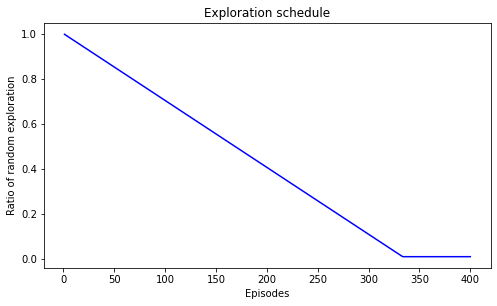

In [21]:

# Exploration Schedule ("linear" or "geometric")
exploration_schedule = "linear"
epsilon_start = 1
epsilon_end   = 0.01

def choose_schedule(exploration_schedule, espilon_start, epsilon_end, episodes):
    if exploration_schedule == "linear":
        epsilon_decay = 1.2*(epsilon_end - epsilon_start)/(episodes-1)
        epsilon_sequence = [1 + epsilon_decay * entry for entry in range(episodes+1)]
        epsilon_sequence = [0.01 if entry < 0.01 else entry for entry in epsilon_sequence]
    elif exploration_schedule == "geometric":
        epsilon_decay = np.power(epsilon_end/epsilon_start, 1./(episodes-1)) # Geometric decay
        epsilon_sequence = [epsilon_start * epsilon_decay ** entry for entry in range(episodes+1)]
        epsilon_sequence = [0.01 if entry < 0.01 else entry for entry in epsilon_sequence]
    elif exploration_schedule == "entropy":
        pass
    else:
        print("ERROR: Unrecognized choice of exploration schedule.")
        
    # Plotting exploration schedule
    plt.figure(figsize=(8,4.5))
    x_series = np.array(range(1,episodes+1))
    y_series = epsilon_sequence[0:episodes]
    plt.plot(x_series, y_series, '-b')
    plt.xlabel('Episodes')
    plt.ylabel('Ratio of random exploration')
    plt.title('Exploration schedule')
    plt.show()
    return(epsilon_sequence)

epsilon_sequence = choose_schedule(exploration_schedule, epsilon_start, epsilon_end, episodes)


In [22]:
# Calculate ACF decay
Triple_MO_Agent = MasterMO_Agent(model_name, vissim_working_directory, sim_length,\
                                 Single_Cross_Triple_dictionary8, actions_set, random_seed,\
                                 timesteps_per_second, Session_ID)

INTERSECTION 0: SETTING UP AGENT


In [23]:
Triple_MO_Agent.get_data()

Working Directory set to: C:\Users\acabrejasegea\Desktop\15_Timescales_utc\gamma_code
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Single_Cross_Triple.inpx ...
Model File load process successful.
Simulation length set to 3601 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                COM SETUP COMPLETE                   *
*                                                     *
*******************************************************

Random seed set in simulator. Random Seed = 10
Deploying Network Parser...
Successful Network Crawl: Identified SignalControllers, Links, Lanes and Vehicle Inputs.

Setting Simulation mode to: training
Starting Deployments of Signal Control Units...
SCUs success

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
Balance_int_MultiDQN_Agents = MasterDQN_Agent(model_name, vissim_working_directory, sim_length, partial_dictionary, actions,\
                gamma, alpha, agent_type, memory_size, PER_activated, batch_size, batches_per_episode, copy_weights_frequency, epsilon_sequence,\
                Random_Seed, timesteps_per_second, Session_ID, verbose = True)


In [ ]:
Balance_int_MultiDQN_Agents.prepopulate_memory()

In [ ]:
Balance_int_MultiDQN_Agents.train(episodes)

In [ ]:
Balance_int_MultiDQN_Agents.save(episodes)

In [ ]:
Balance_int_MultiDQN_Agents.demo()

In [220]:
## ACF STUFF
import statsmodels.tsa.stattools
folder = "C:\\Users\\acabrejasegea\Desktop\\15_Timescales_utc\\gamma_code\\Single_Cross_Triple\\"
file = "as_Q400.pkl"

with open(folder+file, 'rb') as pfile:
    q = pickle.load(pfile)

In [221]:
q[0] = np.asarray([q[0]])
queues = [sum(a[0]) for a in q]

In [225]:
len(queues)

[autoreload of DQNAgents failed: Traceback (most recent call last):
  File "C:\Users\acabrejasegea\AppData\Local\Continuum\anaconda3\envs\vissim\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\acabrejasegea\AppData\Local\Continuum\anaconda3\envs\vissim\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "C:\Users\acabrejasegea\AppData\Local\Continuum\anaconda3\envs\vissim\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "C:\Users\acabrejasegea\AppData\Local\Continuum\anaconda3\envs\vissim\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 604, in _exec
  File "<frozen importlib._bootstrap_external>", line 779, in exec_module
  File "<frozen importlib._bootstrap_external>", line 916, in get_code
  File "<frozen importlib._bootstrap_external

1120

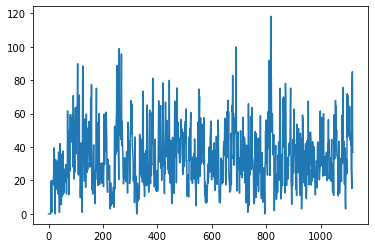

In [222]:
plt.plot(queues)

In [223]:
acf_q = statsmodels.tsa.stattools.acf(queues[600:len(queues)], nlags = 3600)

lim10 = next(x[0] for x in enumerate(acf_q) if x[1] < 0.1)
lim01 = next(x[0] for x in enumerate(acf_q) if x[1] < 0.01)

print("ACF reaches < 10% after {} actions.".format(lim10))
print("This means \N{greek small letter gamma} = {}".format(np.round(np.power(0.1, 1/lim10),3)))
print("\n")
print("ACF reaches < 1% after {} actions.".format(lim01))
print("This means \N{greek small letter gamma} = {}".format(np.round(np.power(0.1, 1/lim01),3)))

ACF reaches < 10% after 7 actions.
This means γ = 0.72


ACF reaches < 1% after 12 actions.
This means γ = 0.825


C:\Users\acabrejasegea\AppData\Local\Continuum\anaconda3\envs\vissim\lib\site-packages\statsmodels\tsa\stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


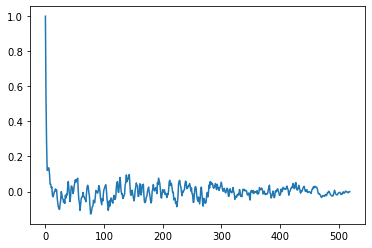

In [224]:
plt.plot(acf_q)